In [186]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
from scipy.optimize import minimize

shape 342 548


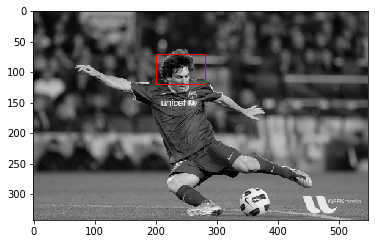

In [187]:
# import Messi
image = cv2.imread('./messi5.jpg')
img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(img, cmap='gray');
rows, cols = img.shape
print('shape', rows, cols)

# and Define a box
x, y, w, h = 200, 70, 80, 50 #60, 70, 100, 50
box_polyline = np.array([[x, x+w, x+w, x, x],
                         [y, y, y+h, y+h, y]]).T
plt.plot(box_polyline[:, 0], box_polyline[:, 1],
         '-', color='red', linewidth=1, label='box');

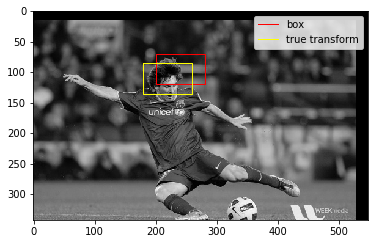

In [189]:
# Transform the image for testing
rows,cols = img.shape

M_test = np.array([[  1.0, 0.0, -20.],
                   [  0.0, 1.0,  15.]])
 
img2 = cv2.warpAffine(img, M_test, (cols,rows),
                      flags=cv2.INTER_CUBIC)

# graph
plt.imshow(img2, cmap='gray');
plt.plot(box_polyline[:, 0], box_polyline[:, 1],
         '-', color='red', linewidth=1, label='box');


xy1 = np.hstack([box_polyline, np.ones((box_polyline.shape[0], 1))])
box_tr = np.matmul(M_test, xy1.T).T
plt.plot(box_tr[:, 0], box_tr[:, 1],
         '-', color='yellow', linewidth=1, label='true transform');
plt.legend();

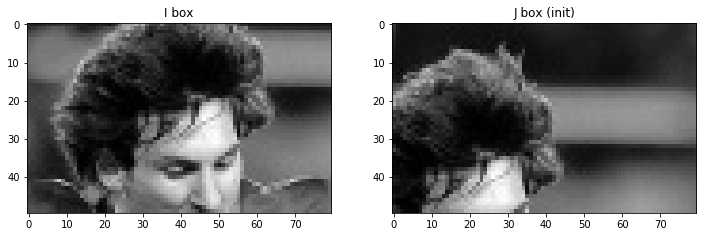

In [190]:
# Crop
# I box
M = np.array([[ 1., 0., -x],
              [ 0., 1., -y]])
 
I_box = cv2.warpAffine(img, M, (w, h),
                   flags=cv2.INTER_LANCZOS4)#INTER_LINEAR)#INTER_CUBIC)

# J box init
M = np.array([[ 1., 0., -x],
              [ 0., 1., -y]])
 
J_init = cv2.warpAffine(img2, M, (w, h),
                    flags=cv2.INTER_LANCZOS4)#INTER_CUBIC)

# Graph
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.imshow(I_box, cmap = 'gray');
ax1.set_title('I box');
ax2.imshow(J_init, cmap = 'gray');
ax2.set_title('J box (init)');

In [114]:
# Comparison function
def normalize(I):
    return (I - I.mean())/I.std()

def znssd(I, J):
    """Zero-normalized sum of squared differences (ZNSSD)"""
    return np.sum( (normalize(I) - normalize(J))**2 )

def ssd(I, J):
    """Zero-normalized sum of squared differences (ZNSSD)"""
    return np.sum( (I - J)**2 )

# test
znssd(I_box, J_init)

4120.635307603454

In [115]:
def opti_fun(M_flat, I, J_full):

    M = M_flat.reshape(2, 3)

    shape = I.T.shape
    J_transformed = cv2.warpAffine(J_full, M, shape,
                                   flags=cv2.INTER_LANCZOS4) #)INTER_LINEAR
    
    return ssd(I, J_transformed)

Optimization terminated successfully.
         Current function value: 377253.000000
         Iterations: 90
         Function evaluations: 226


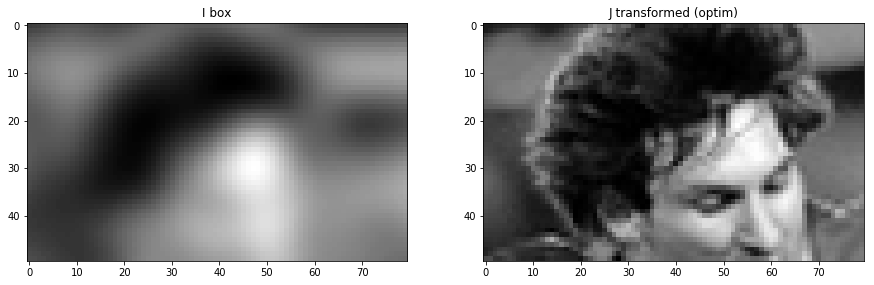

In [54]:
# Minimize
M_init = np.array([[ 1., 0., -x],
                   [ .0, 1., -y]]).flatten()
#M_init = cv2.invertAffineTransform(M_test) - np.array([[0, 0, x], [0, 0, y]])

res = minimize(opti_fun, M_init,
               args=(I_box, img2), options={'disp':True}, method='Nelder-Mead')

M_opt = res.x.reshape(2, 3)

# Solution
J_tr = cv2.warpAffine(img2, M_opt, (w, h),
                      flags=cv2.INTER_CUBIC) #INTER_CUBIC)

# Graph
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.imshow(normalize(I_box), cmap = 'gray');
ax1.set_title('I box');
ax2.imshow(normalize(J_tr), cmap = 'gray');
ax2.set_title('J transformed (optim)');

In [99]:
# Back transformation
translations = np.array([[ 0., 0., x],
                         [ 0., 0., y]])

M_sol = cv2.invertAffineTransform(M_opt + translations)
np.set_printoptions(precision=3, suppress=True)
print('M_sol:')
print(M_sol)

print('M_test:')
print(M_test)

M_sol:
[[ 1.012 -0.     0.   ]
 [ 0.01   1.    -0.   ]]
M_test:
[[  1.1    0.2  -40.  ]
 [ -0.15   1.05  25.  ]]


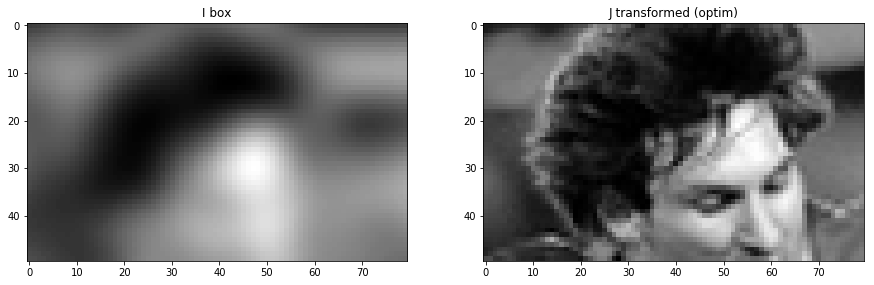

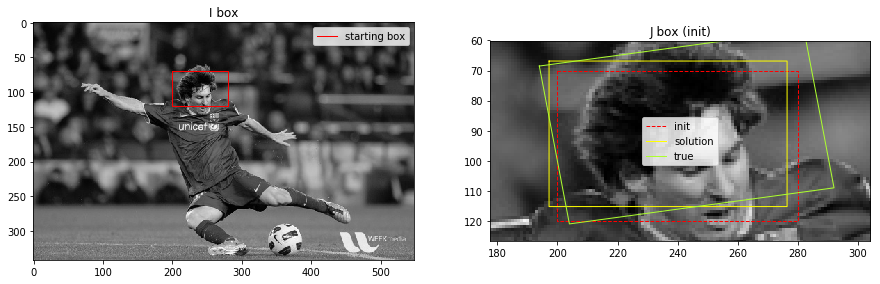

In [56]:
M_opt = res.x.reshape(2, 3)

# Solution
J_tr = cv2.warpAffine(img2, M_opt, (w, h),
                      flags=cv2.INTER_CUBIC) #INTER_CUBIC)

# Graph
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.imshow(normalize(I_box), cmap = 'gray');
ax1.set_title('I box');
ax2.imshow(normalize(J_tr), cmap = 'gray');
ax2.set_title('J transformed (optim)');

# Graph
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.imshow(normalize(img), cmap = 'gray');
ax1.set_title('I box');
ax2.imshow(normalize(img2), cmap = 'gray');
ax2.set_title('J box (init)');

# boxes
ax1.plot(box_polyline[:, 0], box_polyline[:, 1],
         '-', color='red', linewidth=1, label='starting box');
ax1.legend();


ax2.plot(box_polyline[:, 0], box_polyline[:, 1],
         '--', color='red', linewidth=1, label='init');

box_sol = np.matmul(M_sol, xy1.T).T #WAHAT
ax2.plot(box_sol[:, 0], box_sol[:, 1],
         '-', color='yellow', linewidth=1, label='solution');


box_true = np.matmul(M_test, xy1.T).T
ax2.plot(box_tr[:, 0], box_tr[:, 1],
         '-', color='greenyellow', linewidth=1, label='true');

ax2.legend();
# Zoom
ax2.set_xlim(box_sol[:, 0].min()*0.9, box_sol[:, 0].max()*1.1);
ax2.set_ylim(box_sol[:, 1].max()*1.1, box_sol[:, 1].min()*0.9);

## Blur

In [196]:
# Blur
sigma = 15
img_blur = cv2.GaussianBlur(img, (sigma, sigma), 0)
img2_blur = cv2.GaussianBlur(img2, (sigma, sigma), 0)

# Crop
# I box
M = np.array([[ 1., 0., -x],
              [ 0., 1., -y]])
 
I_box = cv2.warpAffine(img_blur, M, (w, h),
                   flags=cv2.INTER_LANCZOS4)#INTER_LINEAR)#INTER_CUBIC)


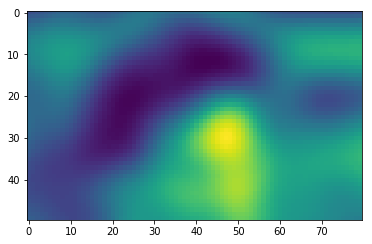

In [192]:
plt.imshow(I_box)

In [150]:
# Minimize
M_init = np.array([[ 1.0, 0.0, -x],
                   [ .0, 1., -y]]).flatten()
#M_init = cv2.invertAffineTransform(M_test) - np.array([[0, 0, x], [0, 0, y]])

In [215]:
opti_fun(np.array([[ 1.0, -0.002, -x+20],
                   [ .0, 1., -y-15]]).flatten(), I_box, img2_blur)

4762

In [160]:
res = minimize(opti_fun, M_init,
               args=(I_box, img2_blur),
               options={'disp':True}, method='Powell')#Nelder-Mead')

M_opt = res.x.reshape(2, 3)

# Back transformation
translations = np.array([[ 0., 0., x],
                         [ 0., 0., y]])

M_sol = cv2.invertAffineTransform(M_opt + translations)
np.set_printoptions(precision=3, suppress=True)
print('M_sol:')
print(M_sol)

print('M_test:')
print(M_test)

Optimization terminated successfully.
         Current function value: 42581.000000
         Iterations: 8
         Function evaluations: 1480
M_sol:
[[ 1.018  0.031 -1.828]
 [-0.035  1.012 -1.962]]
M_test:
[[  1.1    0.2  -40.  ]
 [ -0.15   1.05  25.  ]]


In [162]:
M_init = res.x

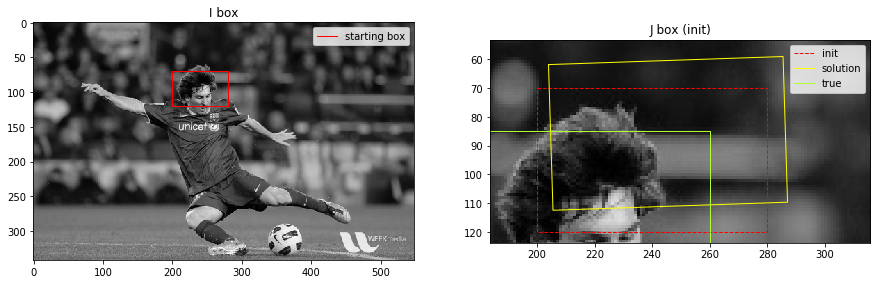

In [198]:
# Graph
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.imshow(normalize(img), cmap = 'gray');
ax1.set_title('I box');
ax2.imshow(normalize(img2), cmap = 'gray');
ax2.set_title('J box (init)');

# boxes
ax1.plot(box_polyline[:, 0], box_polyline[:, 1],
         '-', color='red', linewidth=1, label='starting box');
ax1.legend();


ax2.plot(box_polyline[:, 0], box_polyline[:, 1],
         '--', color='red', linewidth=1, label='init');

box_sol = np.matmul(M_sol, xy1.T).T #WAHAT
ax2.plot(box_sol[:, 0], box_sol[:, 1],
         '-', color='yellow', linewidth=1, label='solution');


box_true = np.matmul(M_test, xy1.T).T
ax2.plot(box_tr[:, 0], box_tr[:, 1],
         '-', color='greenyellow', linewidth=1, label='true');

ax2.legend();
# Zoom
ax2.set_xlim(box_sol[:, 0].min()*0.9, box_sol[:, 0].max()*1.1);
ax2.set_ylim(box_sol[:, 1].max()*1.1, box_sol[:, 1].min()*0.9);

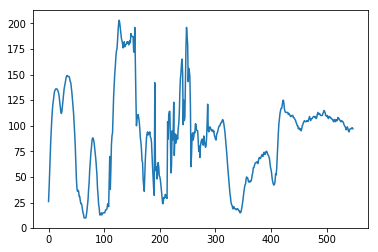

In [217]:
plt.plot(img[115, :])

In [169]:
from scipy.optimize import least_squares

In [193]:
def opti_fun_LM(M_flat, I, J_full):

    M = M_flat.reshape(2, 3)

    shape = I.T.shape
    J_transformed = cv2.warpAffine(J_full, M, shape,
                                   flags=cv2.INTER_LANCZOS4) #)INTER_LINEAR
    
    return (I - J_transformed).flatten()

In [216]:
res = least_squares(opti_fun_LM, M_init,
               args=(I_box, img2_blur), method='lm', diff_step=3)#Nelder-Mead')

M_opt = res.x.reshape(2, 3)

# Back transformation
translations = np.array([[ 0., 0., x],
                         [ 0., 0., y]])

M_sol = cv2.invertAffineTransform(M_opt + translations)
np.set_printoptions(precision=3, suppress=True)
print('M_sol:')
print(M_sol)

print('M_test:')
print(M_test)

M_sol:
[[     3.34       0.065 -65992.353]
 [    -0.084      0.637   5889.278]]
M_test:
[[  1.   0. -20.]
 [  0.   1.  15.]]


In [199]:
M_opt

array([[   0.981,   -0.03 , -198.266],
       [   0.034,    0.987,  -68.001]])

In [180]:
translations

array([[  0.,   0., 200.],
       [  0.,   0.,  70.]])

In [179]:
res.x.reshape(2, 3)

array([[   0.981,   -0.03 , -198.266],
       [   0.034,    0.987,  -68.001]])

def opti_fun_LM(M_flat, I, J_full):

    M = M_flat.reshape(2, 3)

    shape = I.T.shape
    J_transformed = cv2.warpAffine(J_full, M, shape,
                                   flags=cv2.INTER_LANCZOS4) #)INTER_LINEAR
    
    return (I - J_transformed).flags

In [185]:
res

 active_mask: array([0, 0, 0, 0, 0, 0])
        cost: 54231624.0
         fun: array([241., 243., 247., ..., 252., 252., 252.])
        grad: array([1.783e+10, 1.665e+10, 8.896e+07, 4.348e+10, 1.546e+10, 2.229e+08])
         jac: array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])
     message: '`xtol` termination condition is satisfied.'
        nfev: 8
        njev: None
  optimality: 43484184724.74214
      status: 3
     success: True
           x: array([   0.981,   -0.03 , -198.266,    0.034,    0.987,  -68.001])